### Question 2

#### A. Data Source:
[DMO website](https://www.dmo.gov.ng/fgn-bonds/fgn-bond-updates/1935-fgn-bonds-weekly-trading-highlights-report-as-at-february-06-to-february-10-2017/file)

The Government security picked is from NIGERIA, the country of two of the group member

##### About DMO:
DMO is the acronym od Debt Management Office, it was created in October 4, 2000 to coordinate the management of Nigeria's debt. ([Debt Management Office](https://www.dmo.gov.ng/about-dmo))

#### B. Defining the Maturity and Yield array according to the data source

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
maturities = [0.21, 0.46, 0.55, 1.30, 2.38, 2.70, 3.01, 4.42, 4.96, 7.09, 8.95, 11.80, 12.28, 12.78, 13.45, 17.43, 19.10]
yields = [14.05, 18.20, 19.12, 19.79, 16.13, 16.35, 16.56, 16.56, 16.23, 16.20, 16.76, 16.50, 16.46, 16.42, 16.36, 16.00, 16.84 ]
bond_dict = {"Maturity": maturities, "Yield (%)": yields}
bond = pd.DataFrame(bond_dict)
bond

,Maturity,Yield (%)
0,0.21,14.05
1,0.46,18.20
2,0.55,19.12
3,1.30,19.79
4,2.38,16.13
5,2.70,16.35
6,3.01,16.56
7,4.42,16.56
8,4.96,16.23
9,7.09,16.20


##### Plotting the yield curve for the data

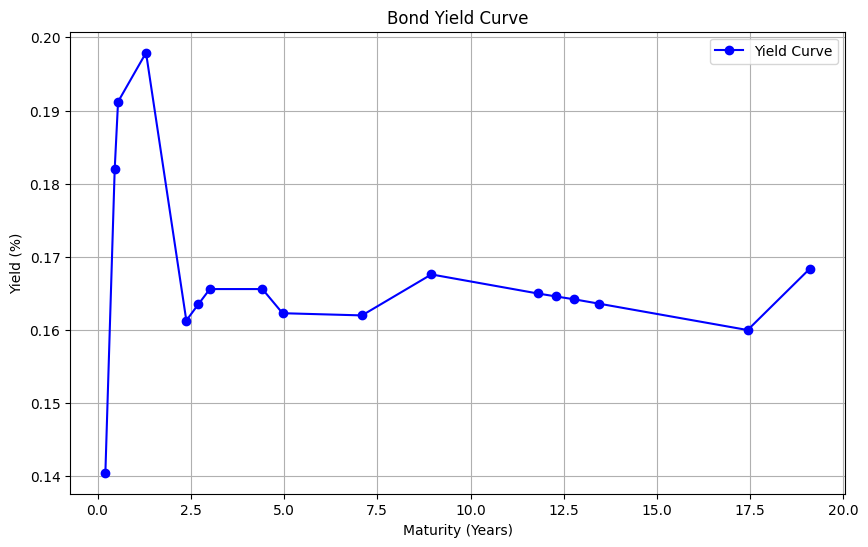

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(bond["Maturity"], bond["Yield (%)"]/100, marker='o', linestyle='-', color='b', label='Yield Curve')
plt.title("Bond Yield Curve")
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield (%)")
plt.legend()
plt.grid(True)
plt.show()

#### C. Fitting Nelson Siegel model

##### Nelson-Siegel Yield Curve Formula

The Nelson-Siegel yield curve is given by:
$$
y(t) = \beta_0 + \beta_1 \cdot \frac{1 - e^{-\lambda t}}{\lambda t} + \beta_2 \cdot \left( \frac{1 - e^{-\lambda t}}{\lambda t} - e^{-\lambda t} \right)
$$

Where:
- $y(t)$: Yield for a given maturity
- $\beta_0$: Long-term level of interest rates
- $\beta_1$: Short-term component
- $\beta_2$: Medium-term component (hump shape)
- $\lambda$: Decay factor controlling the exponential rate of decline

Note: lambda in the formula is the same as tau in the code, I use lambda in the formula because of the ressemblance of tau and t as t is also present in the formula


NelsonSiegelCurve(beta0=np.float64(0.15955966972332303), beta1=np.float64(-0.15098613747320497), beta2=np.float64(0.2995051539138278), tau=np.float64(0.21970466519503065))
Beta0: 0.15955966972332303
Beta1: -0.15098613747320497
Beta2: 0.2995051539138278
Tau: 0.21970466519503065


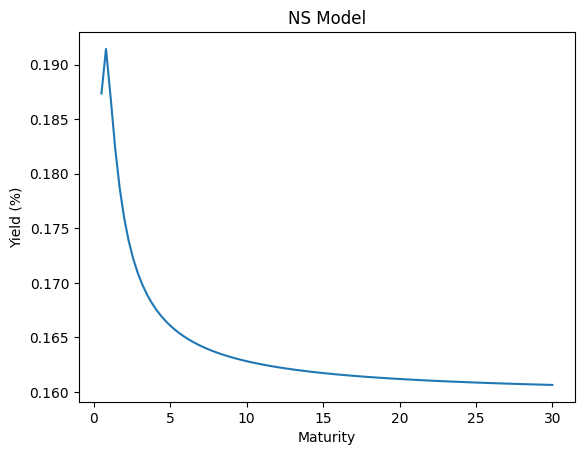

In [15]:
from nelson_siegel_svensson.calibrate import calibrate_ns_ols
t = np.array(bond["Maturity"])
y = np.array(bond["Yield (%)"]/100)
curve, status = calibrate_ns_ols(t, y, tau0 = 1.0) 
assert status.success 
print(curve)

y_ns = curve
t_ns = np.linspace(0.5, 30, 100)
plt.plot(t_ns, y_ns(t_ns))
plt.xlabel("Maturity")
plt.ylabel("Yield (%)")
plt.title("NS Model")

# Extract parameters

beta0 = curve.beta0
beta1 = curve.beta1
beta2 = curve.beta2
tau = curve.tau

print(f"Beta0: {beta0}")
print(f"Beta1: {beta1}")
print(f"Beta2: {beta2}")
print(f"Tau: {tau}")


#### D. Cubic Spline Interpolation

In [16]:
#Selecting the Datapoints for the Interpolation
t_s = np.array([0.55, 3.01, 11.80, 19.10])
y_percent = np.array([19.12, 16.56, 16.50, 16.84])
y_s = y_percent/100
print(y_s)

[0.1912 0.1656 0.165  0.1684]


##### Creating the spline equations

$$
\begin{aligned}
f(x) &= a_1x^3 + b_1x^2 + c_1x + d_1 & \text{when } 0.55 \leq x \leq 3.01 \\
f(x) &= a_2x^3 + b_2x^2 + c_2x + d_2 & \text{when } 3.01 \leq x \leq 11.80 \\
f(x) &= a_3x^3 + b_3x^2 + c_3x + d_3 & \text{when } 11.80 \leq x \leq 19.10
\end{aligned}
$$

##### Each spline will go through two consecutive Datapoints

$$
\begin{aligned}
a_1(0.55)^3 + b_1(0.55)^2 + c_1(0.55) + d_1 = 0.1912 ................................................. (1)\\
a_1(3.01)^3 + b_1(3.01)^2 + c_1(3.01) + d_1 = 0.1656 ................................................ (2)\\
a_2(3.01)^3 + b_2(3.01)^2 + c_2(3.01) + d_2  = 0.1656 ................................................ (3)\\
a_2(11.80)^3 + b_2(11.80)^2 + c_2(11.80) + d_2 = 0.1650 ...............................................(4)\\
a_3(11.80)^3 + b_3(11.80)^2 + c_3(11.80) + d_3= 0.1650 ...............................................(5)\\
a_3(19.10)^3 + b_3(19.10)^2 + c_3(19.10) + d_3 = 0.1684 ...............................................(6)\\
\end{aligned}
$$

##### Obtaining the equation of the first derivative of two consecutive splines, being continuous at their interior point

$$
\begin{align}
3a_1(3.01)^2 + 2b_1(3.01) + c_1 - 3a_2(3.01)^2 - 2b_2(3.01) - c_1 = 0 ...........................(7)\\
3a_2(11.80)^2 + 2b_2(11.80) + c_2 - 3a_3(11.80)^2 - 2b_3(11.80) - c_3 = 0 .......................(8)
\end{align}
$$

##### Obtaining the equation of the second derivative of two consecutive splines continuous at their interior point

$$
\begin{align}
6a_1(3.01) + 2b_1 - 6a_2(3.01) - 2b_2 = 0 ....................................(9)\\
6a_2(11.80) + 2b_2 - 6a_3(11.80) - 2b_3 = 0...................................(10)
\end{align}
$$

##### Obtaining the equations of the boundary conditions

$$
\begin{align}
6a_1(0.55) + 2b_1 = 0 ...............................................(11)\\
6a_3(19.10) + 2b_3 = 0 ..............................................(12)
\end{align}
$$

##### Represnting the equations with matrix

$$
\begin{aligned}
A * c = y\\
c = A^{-1} * y\\
\end{aligned}
$$
<br>
<br>
$$
\begin{bmatrix}
a_1\\
b_1\\
c_1\\
d_1\\
a_2\\
b_2\\
d_2\\
a_3\\
b_3\\
c_3\\
d_3
\end{bmatrix}
= \begin{bmatrix}
0.1664 & 0.3025 & 0.55 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
27.2709 & 9.0601 & 3.01 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 27.2709 & 9.0601 & 3.01 & 1 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 1643.032 & 139.24 & 11.80 & 1 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1643.032 & 139.24 & 11.80 & 1\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 6967.871 & 364.81 & 19.10 & 1\\
27.1803 & 6.02 & 1 & 0 & -27.1803 & -6.02 & -1 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 417.72 & 23.6 & 1 & 0 & -417.72 & -23.6 & -1 & 0\\
18.06 & 2 & 0 & 0 & -18.06 & -2 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 70.8 & 2 & 0 & 0 & -70.8 & -2 & 0 & 0\\
3.33 & 2 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 114.6 & 2 & 0 & 0
\end{bmatrix}^{-1}\bullet\begin{bmatrix}
0.1912\\
0.1656\\
0.1656\\
0.1650\\
0.1650\\
0.1684\\
0\\
0\\
0\\
0\\
0\\
0
\end{bmatrix}
$$

In [1]:
A = np.array([[0.1664, 0.3025, 0.55, 1, 0, 0, 0, 0, 0, 0, 0, 0],
              [27.2709, 9.0601, 3.01, 1, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 27.2709, 9.0601, 3.01, 1, 0, 0, 0, 0],
              [0, 0, 0, 0, 1643.032, 139.24, 11.80, 1, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 1643.032, 139.24, 11.80, 1],
              [0, 0, 0, 0, 0, 0, 0, 0, 6967.871, 364.81, 19.10, 1],
              [27.1803, 6.02, 1, 0, -27.1803, -6.02, -1, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 417.72, 23.6, 1, 0, -417.72, -23.6, -1, 0],
              [18.06, 2, 0, 0, -18.06, -2, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 70.8, 2, 0, 0, -70.8, -2, 0, 0],
              [3.33, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 114.6, 2, 0, 0]])
y = np.array([0.1912, 0.1656, 0.1656, 0.1650, 0.1650, 0.1684, 0, 0, 0, 0, 0, 0])
c = (np.dot(np.linalg.inv(A), y)).reshape(3, -1)
print(c)

NameError: name 'np' is not defined

##### Writting the function that calculates:
$$x^0 + x^1 + x^2 + x^3$$

In [18]:
def spline_interpol(coeffs, variables):
    expansion = np.hstack([coeffs[i]*(variables**i)for i in range(0, len(coeffs))])
    return np.sum(expansion, axis = 1)

##### Simulating 100 values of x and applying the above function to get the respective values of y

In [19]:
x_values = np.linspace(0.55,19.10,500)
# for values of x that are less than 5
y_1 = spline_interpol(c[0][::-1], x_values[x_values < 3.01].reshape(-1, 1))
# for values of x that are greater than or equal to 5 to x < 10
y_2 = spline_interpol(c[1][::-1], x_values[(x_values >= 3.01) & (x_values < 11.80)].reshape(-1, 1))
# from 10 to 30
y_3 = spline_interpol(c[2][::-1], x_values[x_values >= 11.80].reshape(-1, 1))
y_values = np.concatenate([y_1, y_2, y_3])

##### Plotting the result

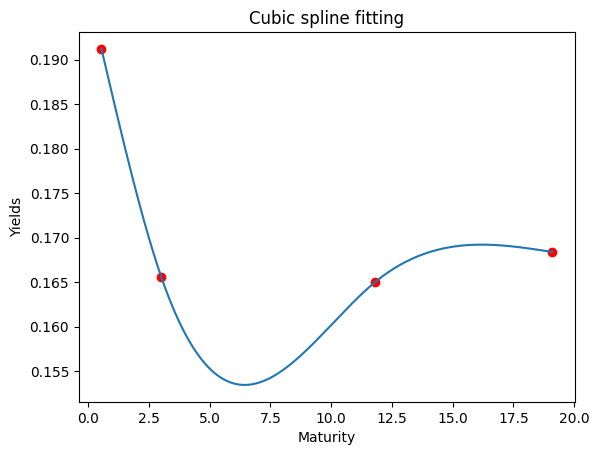

In [20]:
plt.plot(x_values, y_values)
plt.scatter(t_s, y_s, c = "red")
plt.xlabel("Maturity")
plt.ylabel("Yields")
plt.title("Cubic spline fitting")
plt.show()

#### E. Comparison of the models:

##### In terms of fit:

1. NS model is very smooth and is more ideal for capturing general trends. (Nelson & Siegel 473 - 489)
2. Cubic spline model offers high flexibility which gives it the advantage of fixing irregularies in data points and the disadvantage of overfitting ( McCulloch 811 - 830)

##### In terms of interpretation:
1. The parameters of NS fitting has economic meaning capturing long term, short term and medium term yield curve component (Nelson and Siegel 473 - 489)
2. The parameters of cubic spline model are purely mathematical and don't have direct economic interpretation(Adams and Van 1 - 15)

#### F. Parameters:

The parameters are outlined under the codes for each model

##### NS model Parameters:

In [21]:
beta0 = curve.beta0
beta1 = curve.beta1
beta2 = curve.beta2
tau = curve.tau

print(f"Beta0: {beta0}")
print(f"Beta1: {beta1}")
print(f"Beta2: {beta2}")
print(f"Tau: {tau}")

Beta0: 0.15955966972332303
Beta1: -0.15098613747320497
Beta2: 0.2995051539138278
Tau: 0.21970466519503065


##### Cubic Spline Parameters

In [22]:
print(c)

[[ 2.06613038e-04 -3.44010709e-04 -1.14583069e-02  1.97571752e-01]
 [-7.15804569e-05  2.16807655e-03 -1.90196895e-02  2.05158339e-01]
 [ 1.67064667e-05 -9.57280543e-04  1.78595242e-02  6.01000980e-02]]


The parameters of cubic spline are arranged in the pattern below:

the output of the matrix above is of the form:
$$c = \begin{bmatrix}
    a_1 & b_1 & c_1 & d_1 \\
    a_2 & b_2 & c_2 & d_2 \\
    a_3 & b_3 & c_3 & d_3 
\end{bmatrix}$$

#### References:
1. Debt Management Office, "FGN bonds update", 13 february, 2017, https://www.dmo.gov.ng/fgn-bonds/fgn-bond-updates/1935-fgn-bonds-weekly-trading-highlights-report-as-at-february-06-to-february-10-2017/file.
2. Nelson, Charles R., and Andrew F. Siegel. "Parsimonious Modeling of Yield Curves." *The Journal of Business*, vol. 60, no. 4, 1987, pp. 473-489.
3. McCulloch, John H. "The Tax-Adjusted Yield Curve." The Journal of Finance, vol. 30, no. 3, 1975, pp. 811-830.
4. Adams, J., and R. van Deventer. "Maximum Smoothness Forward Rates and Related Yields." Basic Building Blocks of Yield Curve Smoothing, SAS Risk Data and Analytics, 2012, pp. 1-15

In [29]:
###Q3. Exploiting Correlation
#Importing required libraries
import numpy as np


##Q3-a. Generate 5 uncorrelated Gaussian random variables that simulate yield changes

# Setting the mean and standard deviation
mean = 0
std_dev = 1

# Generating 5 uncorrelated Gaussian random variables
random_variables = np.random.normal(mean, std_dev, 5)

print("The 5 Generated Gaussian random variables are:",random_variables)

The 5 Generated Gaussian random variables are: [ 0.97565612  0.92651486 -1.36385173 -0.51372004  0.78090891]


In [30]:
##Q3-b.Run a Principal Components using covariance matrix

#Generating a sample data matrix with multiple observations
data = np.array ([np.random.normal(mean, std_dev,5) for _ in range (100)])

#Computing the covariance matrix
cov_matrix = np.cov(data, rowvar=False)

#Performing Eigen decomposition of the covariance matrix
eigen_values, eigen_vectors = np.linalg.eigh(cov_matrix)

#Sortng the eigenvalues and eigenvectors in descending order
sorted_indices = np.argsort(eigen_values)[::-1]
eigen_values = eigen_values [sorted_indices]
eigen_vectors = eigen_vectors[:, sorted_indices]

#Transforming the original data using the eigenvectors (PCA)
principal_components = np.dot(data, eigen_vectors)

#Printing results
print ("Covariance Matrix:\n", cov_matrix)
print ("\nEigenvalues:\n", eigen_values)
print ("\nEigenvectors (Principal Components):\n", eigen_vectors)
print ("\nTransformed Data (Principal Components:\n)", principal_components)

Covariance Matrix:
 [[ 0.90687641  0.04941727 -0.02465286 -0.08303729 -0.08815619]
 [ 0.04941727  1.16973813  0.31192471 -0.01874414  0.01242591]
 [-0.02465286  0.31192471  1.24043299  0.00920335 -0.28766277]
 [-0.08303729 -0.01874414  0.00920335  1.01600154  0.1471352 ]
 [-0.08815619  0.01242591 -0.28766277  0.1471352   1.20492249]]

Eigenvalues:
 [1.64675205 1.2555874  1.04172668 0.86672013 0.7271853 ]

Eigenvectors (Principal Components):
 [[ 0.08293956  0.19598244  0.46895444  0.775409   -0.36542376]
 [ 0.46363772 -0.57477992  0.4721844   0.03631621  0.47999076]
 [ 0.70815824 -0.18917087 -0.31552822 -0.11581475 -0.59140103]
 [-0.1330719  -0.42553581 -0.634837    0.59910717  0.19815076]
 [-0.50888592 -0.64370224  0.23355418 -0.15836525 -0.49704672]]

Transformed Data (Principal Components:
) [[-0.10061956  0.57892485 -0.10183904 -0.52510065 -0.37515534]
 [-0.59267847  0.60908959 -0.19968263  0.190379    0.50738367]
 [-0.84631649  0.70444827  0.16656197 -1.32470203 -0.38093291]
 [-0.

In [31]:
##Q3-c.Write a paragraph explaining how the variances of each component compare
        #with each other. In this paragraph, you will address the following question: how
        #much variance is explained by Component 1, Component 2, Component 3?

#calculating the total variance
total_variance = np.sum(eigen_values)  

#calculating the proportion of the variance explained by each component
variance_explained = eigen_values / total_variance

print ("variance explained by each component:", variance_explained)
print ("variance explained by component 1:\n", variance_explained[0])
print ("variance explained by component 2:\n", variance_explained[1])
print ("variance explained by component 3:\n", variance_explained[3])


variance explained by each component: [0.29735654 0.22672334 0.18810618 0.15650498 0.13130896]
variance explained by component 1:
 0.2973565382914144
variance explained by component 2:
 0.2267233378203831
variance explained by component 3:
 0.15650497955758685


In [8]:
'''

Following the results obtained above, Component 1 has the highest 
contribution,explaining 29.74% of the overall variance, Component 2
follows with a contribution of 22.67% to the variance, while
Component 3 accounts for approximately 15.65% of the
total variance. The remaining components contribute 
smaller portions, indicating thatthey capture less significant 
variations in the data. Overall, the first three components 
collectively explain almost 68% of the total variance.

In [ ]:
import pandas as pd
import numpy as np
import pandas_datareader.data as web
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


def fetch_treasury_data(start_date, end_date):
    """
    Fetches daily treasury yield data from FRED database
    Parameters:
    start_date (datetime): Start date for data collection
    end_date (datetime): End date for data collection
    Returns:
    pandas.DataFrame: Daily yields for different maturities
    """
    # Treasury securities tickers for different maturities
    tickers = {
        'DGS1MO': '1-Month',
        'DGS3MO': '3-Month',
        'DGS6MO': '6-Month',
        'DGS1': '1-Year',
        'DGS2': '2-Year'
    }
    
    df = pd.DataFrame()
    
    # Fetch data for each security
    for ticker, name in tickers.items():
        try:
            data = web.DataReader(ticker, 'fred', start_date, end_date)
            df[name] = data
        except Exception as e:
            print(f"Error fetching {ticker}: {e}")
    
    return df.dropna()  # Remove any rows with missing values

##Q3-f. Be sure to compute the daily yield changes!

def calculate_daily_changes(yields_df):
    """
    Calculates daily changes in yields
    Parameters:
    yields_df (pandas.DataFrame): DataFrame containing daily yields
    Returns:
    pandas.DataFrame: Daily yield changes
    """
    return yields_df.diff().dropna()

def perform_pca(yield_changes):
    """
    Performs PCA on yield changes using the covariance matrix
    Parameters:
    yield_changes (pandas.DataFrame): DataFrame containing daily yield changes
    Returns:
    tuple: (PCA object, explained variance ratios, transformed data)
    """
    # Create covariance matrix
    cov_matrix = np.cov(yield_changes.T)
    
    # Perform PCA
    pca = PCA()
    pca_result = pca.fit_transform(yield_changes)
    
    return pca, pca.explained_variance_ratio_, pca_result

def plot_scree(explained_variance_ratio):
    """
    Creates a scree plot of explained variance ratios
    Parameters:
    explained_variance_ratio (array): Array of explained variance ratios
    """
    plt.figure(figsize=(10, 6))
    
    # Bar plot of explained variance
    plt.bar(range(1, len(explained_variance_ratio) + 1), 
            explained_variance_ratio * 100,
            alpha=0.5,
            color='blue')
    
    # Line plot of cumulative explained variance
    plt.plot(range(1, len(explained_variance_ratio) + 1),
             np.cumsum(explained_variance_ratio) * 100,
             'ro-',
             label='Cumulative Explained Variance')
    
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance (%)')
    plt.title('Scree Plot of PCA Components')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def print_component_loadings(pca, column_names):
    """
    Prints the loadings (eigenvectors) for each principal component
    Parameters:
    pca (PCA): Fitted PCA object
    column_names (list): Names of the original variables
    """
    loadings = pd.DataFrame(
        pca.components_.T,
        columns=[f'PC{i+1}' for i in range(len(column_names))],
        index=column_names
    )
    print("\nPrincipal Component Loadings:")
    print(loadings)
    return loadings

# Main execution
if __name__ == "__main__":
    # Define date range (last 6 months)
    end_date = datetime.now()
    start_date = end_date - timedelta(days=180)
    
    # 1. Collect daily closing yields
    print("Fetching treasury yield data...")
    yields_df = fetch_treasury_data(start_date, end_date)
    print(f"Collected {len(yields_df)} days of yield data\n")
    
    # 2. Compute daily changes
    print("Calculating daily yield changes...")
    yield_changes = calculate_daily_changes(yields_df)
    print("First few rows of yield changes:")
    print(yield_changes.head())
    print("\nDescriptive statistics of yield changes:")
    print(yield_changes.describe())
    
    # Print correlation matrix
    print("\nCorrelation matrix of yield changes:")
    print(yield_changes.corr().round(3))
    
    # 3. Run PCA
    print("\nPerforming PCA analysis...")
    pca, explained_variance_ratio, pca_result = perform_pca(yield_changes)
    
    # Print explained variance ratios
    print("\nExplained variance ratio by component:")
    for i, ratio in enumerate(explained_variance_ratio, 1):
        print(f"PC{i}: {ratio*100:.2f}%")
    
    # Print component loadings
    loadings = print_component_loadings(pca, yield_changes.columns)
    
    # 4. Create scree plot
    print("\nGenerating scree plot...")
    plot_scree(explained_variance_ratio)

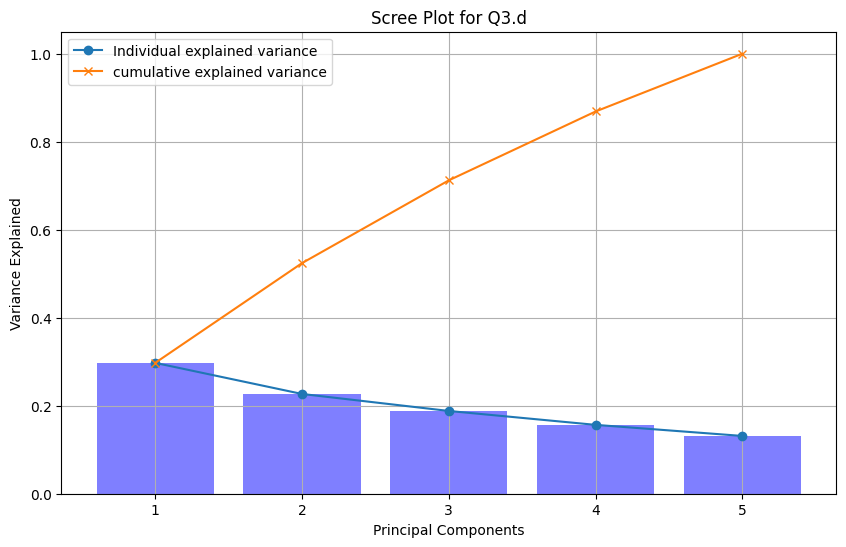

In [33]:
##Q3-d: Produce a screeplot (see https://en.wikipedia.org/wiki/Scree_plot) of the
#variance explained for each component.

#Importing required libraries
import matplotlib.pyplot as plt
#calculating cumulative variance explained
cumulative_variance_explained = np.cumsum(variance_explained)

#creating the scree plot
plt.figure(figsize=(10,6))
plt.plot(range(1, len(variance_explained) + 1), 
         variance_explained, marker = 'o', 
         label = 'Individual explained variance')
plt.plot(range(1, len(cumulative_variance_explained) +1), 
         cumulative_variance_explained, marker = 'x', 
         label = 'cumulative explained variance')
plt.bar(range(1, len(variance_explained) + 1), 
            variance_explained,
            alpha=0.5,
            color='blue')
#labeling the scree plot
plt.title('Scree Plot for Q3.d')
plt.xlabel('Principal Components')
plt.ylabel('Variance Explained')
plt.xticks(range(1, len(variance_explained) + 1))
plt.legend()
plt.grid()
plt.show()

In [ ]:
### Working with real data:
!pip install pandas-datareader


Fetching treasury yield data...
Collected 119 days of yield data

Calculating daily yield changes...
First few rows of yield changes:
            1-Month  3-Month  6-Month  1-Year  2-Year
DATE                                                 
2024-07-29     0.01     0.03     0.00    0.00    0.00
2024-07-30     0.00    -0.01    -0.02   -0.01   -0.01
2024-07-31    -0.01     0.01    -0.02   -0.05   -0.06
2024-08-01     0.06    -0.04    -0.06   -0.11   -0.13
2024-08-02    -0.01    -0.08    -0.20   -0.29   -0.28

Descriptive statistics of yield changes:
          1-Month     3-Month     6-Month      1-Year      2-Year
count  118.000000  118.000000  118.000000  118.000000  118.000000
mean    -0.008983   -0.008814   -0.007797   -0.005169   -0.001102
std      0.033802    0.026704    0.033388    0.051186    0.061793
min     -0.140000   -0.110000   -0.200000   -0.290000   -0.280000
25%     -0.027500   -0.020000   -0.020000   -0.030000   -0.030000
50%     -0.010000   -0.010000   -0.005000   -0.010

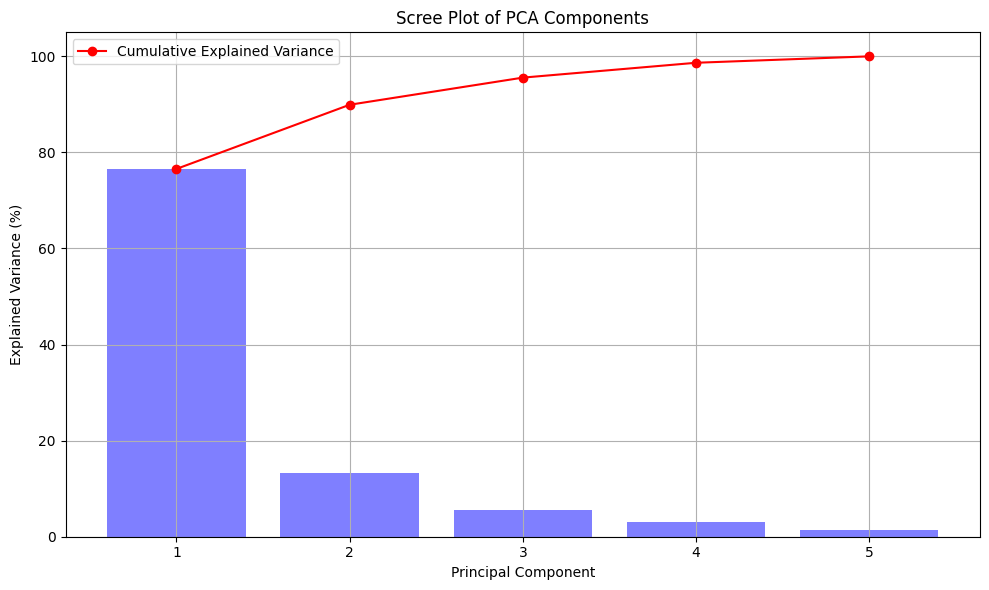

In [27]:
import pandas as pd
import numpy as np
import pandas_datareader.data as web
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#Definition of functions used in the main program

def fetch_treasury_data(start_date, end_date):
    """
    Fetches daily treasury yield data from FRED database
    Parameters:
    start_date (datetime): Start date for data collection
    end_date (datetime): End date for data collection
    Returns:
    pandas.DataFrame: Daily yields for different maturities
    """
    # Treasury securities tickers for different maturities
    tickers = {
        'DGS1MO': '1-Month',
        'DGS3MO': '3-Month',
        'DGS6MO': '6-Month',
        'DGS1': '1-Year',
        'DGS2': '2-Year'
    }
    
    df = pd.DataFrame()
    
    # Fetch data for each security
    for ticker, name in tickers.items():
        try:
            data = web.DataReader(ticker, 'fred', start_date, end_date)
            df[name] = data
        except Exception as e:
            print(f"Error fetching {ticker}: {e}")
    
    return df.dropna()  # Remove any rows with missing values

def calculate_daily_changes(yields_df):
    """
    Calculates daily changes in yields
    Parameters:
    yields_df (pandas.DataFrame): DataFrame containing daily yields
    Returns:
    pandas.DataFrame: Daily yield changes
    """
    return yields_df.diff().dropna()

def perform_pca(yield_changes):
    """
    Performs PCA on yield changes using the covariance matrix
    Parameters:
    yield_changes (pandas.DataFrame): DataFrame containing daily yield changes
    Returns:
    tuple: (PCA object, explained variance ratios, transformed data)
    """
    # Create covariance matrix
    cov_matrix = np.cov(yield_changes.T)
    
    # Perform PCA
    pca = PCA()
    pca_result = pca.fit_transform(yield_changes)
    
    return pca, pca.explained_variance_ratio_, pca_result

def plot_scree(explained_variance_ratio):
    """
    Creates a scree plot of explained variance ratios
    Parameters:
    explained_variance_ratio (array): Array of explained variance ratios
    """
    plt.figure(figsize=(10, 6))
    
    # Bar plot of explained variance
    plt.bar(range(1, len(explained_variance_ratio) + 1), 
            explained_variance_ratio * 100,
            alpha=0.5,
            color='blue')
    
    # Line plot of cumulative explained variance
    plt.plot(range(1, len(explained_variance_ratio) + 1),
             np.cumsum(explained_variance_ratio) * 100,
             'ro-',
             label='Cumulative Explained Variance')
    
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance (%)')
    plt.title('Scree Plot of PCA Components')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def print_component_loadings(pca, column_names):
    """
    Prints the loadings (eigenvectors) for each principal component
    Parameters:
    pca (PCA): Fitted PCA object
    column_names (list): Names of the original variables
    """
    loadings = pd.DataFrame(
        pca.components_.T,
        columns=[f'PC{i+1}' for i in range(len(column_names))],
        index=column_names
    )
    print("\nPrincipal Component Loadings:")
    print(loadings)
    return loadings

# Main execution
if __name__ == "__main__":
    # Defining date range (last 6 months)
    end_date = datetime.now()
    start_date = end_date - timedelta(days=180)
    
    # Q3-e Collecting daily closing yields
    print("Fetching treasury yield data...")
    yields_df = fetch_treasury_data(start_date, end_date)
    print(f"Collected {len(yields_df)} days of yield data\n")
    
    # Q3-f. Computing daily changes
    print("Calculating daily yield changes...")
    yield_changes = calculate_daily_changes(yields_df)
    print("First few rows of yield changes:")
    print(yield_changes.head())
    print("\nDescriptive statistics of yield changes:")
    print(yield_changes.describe())
    
    # Checkpoint: Printing correlation matrix
    print("\nCorrelation matrix of yield changes:")
    print(yield_changes.corr().round(3))
    
    # 3-g Runing PCA using covariance matrix
    print("\nPerforming PCA analysis...")
    pca, explained_variance_ratio, pca_result = perform_pca(yield_changes)
    
    # Print explained variance ratios
    print("\nExplained variance ratio by component:")
    for i, ratio in enumerate(explained_variance_ratio, 1):
        print(f"PC{i}: {ratio*100:.2f}%")
    
    # Checkpoint Printing component loadings
    loadings = print_component_loadings(pca, yield_changes.columns)
    
    # 3-1. Creating a scree plot
    print("\nGenerating scree plot...")
    plot_scree(explained_variance_ratio)

In [ ]:
'''
3.h How do the variances of each component compare? In other words, how much
variance is explained by Component 1, Component 2, Component 3, etc.?
Explained variance ratio by component:
PC1: explains 76.57% of the total variance
PC2: explains 13.35% of the total variance
PC3: explains 5.65% of the total variance
PC4: explains 3.09% of the total variance
PC5: explains 1.34% of the total variance

PC1 captures the majority of the variance ie 76.57%, followed by PC2 and PC3. 
PC1 and PC2 alone captures almost 90% of the total variance
'''

In [ ]:
'''
3-j. How does the screeplot from the uncorrelated data compare with the screeplot
from the government data?

Comparing the screeplot from the uncorrelated data with the screeplot 
from the government data reveals notable differences in how the variance
is distributed across the principal components. In the uncorrelated data, 
the variance explained by the firstthree principal components 
(29.74%, 22.67%, and 15.65%, respectively) collectively accounts 
for around 68% of the total variance. This indicates a more
gradual decline in the amount of variance captured by each subsequent component. 

Conversely, in the government data, the first three components 
(76.57%, 13.35%, and 5.65%, respectively) explain approximately 95.57% of the
total variance, with a sharp drop-off after the first principal
component. This steep decline in the government data suggests that
the majority of the variance isconcentrated in the first component, 
while the remaining components capture relatively small portions
of the data's variability.

The practical and useful application of PCA in real-world data analysis
is evident in the comparison of these two screeplots. With the government 
data, PCA effectively reduces the dimensionality of the dataset 
by identifying that the first component alone captures the majority
of the variance. This allows for a more simplified and efficient representation 
of the data without losing significant information, which is particularly 
valuable in the field of finance where datasets are large and complex.

'''

In [1]:
import pandas as pd
import yfinance as yf

# Specify the ETF ticker and date range
ticker = 'XLRE'
start_date = '2024-07-01'
end_date = '2024-12-31'

# Fetch the ETF holdings manually or via an online API (this step assumes we have a predefined list of holdings)
holdings = [
    'PLD', 'EQIX', 'AMT', 'WELL', 'DLR', 'SPG', 'O', 'PSA', 'CCI', 'CBRE',
    'EXR', 'AVB', 'VICI', 'IRM', 'CSGP', 'VTR', 'EQR', 'SBAC', 'WY', 'ESS',
    'INVH', 'MAA', 'ARE', 'KIM', 'DOC', 'UDR', 'HST', 'CPT', 'REG', 'BXP'
]

# Fetch historical price data for all holdings
all_data = {}
for holding in holdings:
    print(f"Fetching data for {holding}...")
    try:
        data = yf.download(holding, start=start_date, end=end_date)
        data['Daily_Returns'] = data['Close'].pct_change()
        all_data[holding] = data['Daily_Returns']
        print(f"Data for {holding} fetched successfully!")
    except Exception as e:
        print(f"Error fetching data for {holding}: {e}")

# Combine the data into a single DataFrame
returns_df = pd.DataFrame(all_data)

# Drop rows with NaN values
returns_df = returns_df.dropna()

# Compute the covariance matrix
cov_matrix = returns_df.cov()

# Save the covariance matrix to a CSV file
cov_output_file = 'etfdata/XLRE_Holdings_Covariance_Matrix.csv'
cov_matrix.to_csv(cov_output_file)

print(f"Covariance matrix computed and saved to: {cov_output_file}")

# Display the covariance matrix
print("Displaying the covariance matrix:")
print(cov_matrix)


Fetching data for PLD...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data for PLD fetched successfully!
Fetching data for EQIX...
Data for EQIX fetched successfully!
Fetching data for AMT...
Data for AMT fetched successfully!
Fetching data for WELL...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data for WELL fetched successfully!
Fetching data for DLR...
Data for DLR fetched successfully!
Fetching data for SPG...
Data for SPG fetched successfully!
Fetching data for O...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data for O fetched successfully!
Fetching data for PSA...
Data for PSA fetched successfully!
Fetching data for CCI...
Data for CCI fetched successfully!
Fetching data for CBRE...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data for CBRE fetched successfully!
Fetching data for EXR...
Data for EXR fetched successfully!
Fetching data for AVB...
Data for AVB fetched successfully!
Fetching data for VICI...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data for VICI fetched successfully!
Fetching data for IRM...
Data for IRM fetched successfully!
Fetching data for CSGP...
Data for CSGP fetched successfully!
Fetching data for VTR...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data for VTR fetched successfully!
Fetching data for EQR...
Data for EQR fetched successfully!
Fetching data for SBAC...
Data for SBAC fetched successfully!
Fetching data for WY...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data for WY fetched successfully!
Fetching data for ESS...
Data for ESS fetched successfully!
Fetching data for INVH...
Data for INVH fetched successfully!
Fetching data for MAA...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data for MAA fetched successfully!
Fetching data for ARE...
Data for ARE fetched successfully!
Fetching data for KIM...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data for KIM fetched successfully!
Fetching data for DOC...
Data for DOC fetched successfully!
Fetching data for UDR...


[*********************100%***********************]  1 of 1 completed


Data for UDR fetched successfully!
Fetching data for HST...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data for HST fetched successfully!
Fetching data for CPT...
Data for CPT fetched successfully!
Fetching data for REG...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Data for REG fetched successfully!
Fetching data for BXP...
Data for BXP fetched successfully!
Covariance matrix computed and saved to: etfdata/XLRE_Holdings_Covariance_Matrix.csv
Displaying the covariance matrix:
           PLD      EQIX       AMT      WELL       DLR       SPG         O   
PLD   0.000242  0.000098  0.000118  0.000064  0.000062  0.000116  0.000078  \
EQIX  0.000098  0.000173  0.000098  0.000055  0.000159  0.000070  0.000037   
AMT   0.000118  0.000098  0.000276  0.000061  0.000071  0.000061  0.000120   
WELL  0.000064  0.000055  0.000061  0.000146  0.000059  0.000077  0.000059   
DLR   0.000062  0.000159  0.000071  0.000059  0.000265  0.000073  0.000015   
SPG   0.000116  0.000070  0.000061  0.000077  0.000073  0.000180  0.000067   
O     0.000078  0.000037  0.000120  0.000059  0.000015  0.000067  0.000112   
PSA   0.000129  0.000107  0.000176  0.000090  0.000097  0.000115  0.000108   
CCI   0.000106  0.000074  0.000185  0.000066  0.000051  0.000063  0.000096   
CBRE  

In [2]:
from sklearn.decomposition import PCA
import numpy as np

# Perform PCA on the daily returns
print("Performing PCA...")
pca = PCA()
pca.fit(returns_df)

# Extract PCA results
eigenvalues = pca.explained_variance_
eigenvectors = pca.components_
explained_variance_ratio = pca.explained_variance_ratio_

# Save PCA results to CSV files
np.savetxt('etfdata/PCA_Eigenvalues.csv', eigenvalues, delimiter=',')
np.savetxt('etfdata/PCA_Eigenvectors.csv', eigenvectors, delimiter=',')
np.savetxt('etfdata/PCA_Explained_Variance_Ratio.csv', explained_variance_ratio, delimiter=',')

print("PCA completed.")
print("Eigenvalues:", eigenvalues)
print("Explained Variance Ratio:", explained_variance_ratio)


Performing PCA...
PCA completed.
Eigenvalues: [2.96434731e-03 5.29146684e-04 5.24179032e-04 3.74450791e-04
 2.46364176e-04 1.95793386e-04 1.66421538e-04 1.24935882e-04
 1.11947617e-04 1.06674279e-04 8.71470045e-05 8.00792008e-05
 6.95598032e-05 6.71878436e-05 6.13022393e-05 5.14403018e-05
 4.91260454e-05 4.21258116e-05 3.98885856e-05 3.82149865e-05
 3.29917800e-05 2.58857014e-05 2.39912205e-05 2.04712486e-05
 1.79354448e-05 1.66139455e-05 1.12955118e-05 8.56802169e-06
 7.97479562e-06 6.45140603e-06]
Explained Variance Ratio: [0.48575857 0.08670966 0.08589562 0.06136011 0.04037095 0.03208407
 0.02727099 0.02047286 0.01834452 0.01748039 0.01428051 0.01312233
 0.01139855 0.01100987 0.01004541 0.00842937 0.00805014 0.00690303
 0.00653642 0.00626217 0.00540626 0.00424181 0.00393137 0.00335456
 0.00293903 0.00272248 0.00185096 0.00140402 0.00130681 0.00105717]


In [3]:
from numpy.linalg import svd
import numpy as np

# Perform Singular Value Decomposition (SVD) on the daily returns
print("Performing SVD...")
U, Sigma, Vt = svd(returns_df, full_matrices=False)

# Save SVD results to CSV files
np.savetxt('etfdata/SVD_U.csv', U, delimiter=',')
np.savetxt('etfdata/SVD_Sigma.csv', Sigma, delimiter=',')
np.savetxt('etfdata/SVD_Vt.csv', Vt, delimiter=',')

# Display the singular values
print("SVD completed.")
print("Singular Values (Sigma):", Sigma)

Performing SVD...
SVD completed.
Singular Values (Sigma): [0.61038801 0.25718633 0.25606936 0.21828746 0.17554649 0.15909967
 0.14423152 0.12562303 0.11844206 0.11566354 0.10686279 0.10014129
 0.09334947 0.0917205  0.08844379 0.08056252 0.07846066 0.07321125
 0.07135243 0.0693344  0.06423506 0.05689221 0.05480635 0.05083874
 0.04739841 0.04557295 0.03757755 0.03275304 0.03172439 0.0283986 ]
